# Objective

The goal of this project is to experiment with different kinds of negation in SPARQL.

As a use-case, we will study the components of molecular complexes in Reactome (https://reactome.org/), which is available in the BioPAX format (http://www.biopax.org/).

# Resources

- Reactome
    - BioPAX file: https://reactome.org/download/current/biopax.zip (extract `Homo_sapiens.owl`)
    - SPARQL endpoint:
- BioPAX
    - website: http://www.biopax.org/
    - specification: http://www.biopax.org/release/biopax-level3-documentation.pdf
    - ontology: http://www.biopax.org/release/biopax-level3.owl
    - tutorial: https://gitlab.com/odameron/BioPAXtutorial
- SPARQL negation: https://gitlab.com/odameron/sparqlNegation

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

# Setup and initialisation

For setting up a local endpoint with fuseki:

```bash
${FUSEKI_HOME}/fuseki-server --file=Homo_sapiens-20210608.owl --file=biopax-level3.owl /reactome
```

Interface:
- for scripts: http://localhost:3030/reactome/query
- for humans: http://localhost:3030/dataset.html?tab=query&ds=/reactome

In [2]:
reactomeVersion = 77
endpointURL = "http://localhost:3030/reactome/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

# Homo_sapiens-20170221.owl
#PREFIX reactome: <http://www.reactome.org/biopax/59/48887#> 
#
# Homo_sapiens-20210608.owl
PREFIX reactome: <http://www.reactome.org/biopax/77/48887#>
"""

# Setup: explore the complexes and their composition

## Number of molecular complexes

In [4]:
query="""
# All complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbComplexes
0       14631

## Complexes and their components

In [5]:
query="""
# All complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbComplexes
0       13789

13789 < 14631 !

Some complexes may **not** have components (or more precisely "the components of some complexes are **not** explicitely represented")

In [6]:
query="""
# All complexes

SELECT ?complexLabel ?componentLabel
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  OPTIONAL { ?complex bp3:displayName ?complexLabel . }
  OPTIONAL { ?component bp3:displayName ?componentLabel . }
}
LIMIT 10
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complexLabel  \
0         2SUMO1:NR3C1:Glucocorticoid ligand dimer   
1                                     THBS1 trimer   
2                    TRAF1:TRAF2:K63polyUb-cIAP1,2   
3                    TRAF1:TRAF2:K63polyUb-cIAP1,2   
4                                         ME1:Mg2+   
5                                         ME1:Mg2+   
6                                Nonameric complex   
7                                Nonameric complex   
8  PRKAR1A(1-183)-p-7Y ALK(1058-1620) fusion dimer   
9                                 active caspase-6   

                       componentLabel  
0  2SUMO1:NR3C1:Glucocorticoid ligand  
1                               THBS1  
2                   K63polyUb-cIAP1,2  
3                               TRAF2  
4                                 ME1  
5                                Mg2+  
6       MHC II alpha beta heterodimer  
7              Invariant chain trimer  
8                          KAP0_HUMAN  
9               caspase-6 heterodimer

## How many complex-composition relations?

In [7]:
query="""
# All complexes

SELECT (count(*) as ?nbCompositionRelations)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbCompositionRelations
0                  32892

## How many complex components?

In [8]:
query="""
# All complexes components

SELECT (count(DISTINCT ?component) as ?nbComponents)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbComponents
0        17782

## Distribution of the number of (direct) components for a complex

In [9]:
query="""
# Complexes and their components

SELECT ?complex ?complexLabel (COUNT(DISTINCT ?component) as ?nbComponents)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  OPTIONAL { ?complex bp3:displayName ?complexLabel . }
  #OPTIONAL { ?component bp3:displayName ?componentLabel . }
}
GROUP BY ?complex ?complexLabel
ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complex  \
0      http://www.reactome.org/biopax/77/48887#Comple...   
1      http://www.reactome.org/biopax/77/48887#Comple...   
2      http://www.reactome.org/biopax/77/48887#Comple...   
3      http://www.reactome.org/biopax/77/48887#Comple...   
4      http://www.reactome.org/biopax/77/48887#Comple...   
...                                                  ...   
13784  http://www.reactome.org/biopax/77/48887#Comple...   
13785  http://www.reactome.org/biopax/77/48887#Comple...   
13786  http://www.reactome.org/biopax/77/48887#Comple...   
13787  http://www.reactome.org/biopax/77/48887#Comple...   
13788  http://www.reactome.org/biopax/77/48887#Comple...   

                                          complexLabel nbComponents  
0                                           Centrosome           65  
1                               Spliceosomal B Complex           65  
2           centrosome without CEP164, CCP110 or CEP97           63  
3                                           centrosome           62  
4             centrosome containing phosphorylated Nlp           62  
...                                                ...          ...  
13784                             Connexin 43 connexon            1  
13785                             Connexin 26 Connexon            1  
13786                                      Connexon 26            1  
13787  Connexin 43 connexon in Golgi transport vesicle            1  
13788                                           DIAPH1            1  

[13789 rows x 3 columns]

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

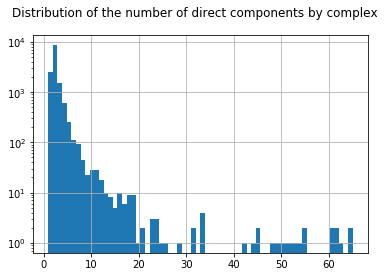

In [10]:
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

## Distribution of the number of complexes a complex component is a component of

In [11]:
query="""
# Complexes and their components

SELECT ?component (COUNT(DISTINCT ?complex) as ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  #OPTIONAL { ?complex bp3:displayName ?complexLabel . }
  #OPTIONAL { ?component bp3:displayName ?componentLabel . }
}
GROUP BY ?component
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

component nbComplexes
0      http://www.reactome.org/biopax/77/48887#Physic...           2
1      http://www.reactome.org/biopax/77/48887#SmallM...           1
2      http://www.reactome.org/biopax/77/48887#Comple...           1
3      http://www.reactome.org/biopax/77/48887#Protei...           1
4      http://www.reactome.org/biopax/77/48887#Protei...           1
...                                                  ...         ...
17777  http://www.reactome.org/biopax/77/48887#Comple...           2
17778  http://www.reactome.org/biopax/77/48887#Comple...           1
17779  http://www.reactome.org/biopax/77/48887#Protei...           3
17780  http://www.reactome.org/biopax/77/48887#Protei...           3
17781  http://www.reactome.org/biopax/77/48887#Comple...           1

[17782 rows x 2 columns]

Text(0.5, 0.98, 'Distribution of the number of complexes a component is a direct component of')

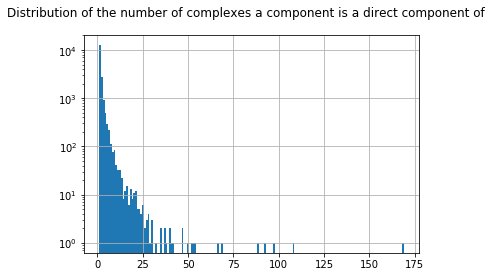

In [12]:
df["nbComplexes"] = pandas.to_numeric(df["nbComplexes"])
df['nbComplexes'].hist(bins=df['nbComplexes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a component is a direct component of")

## What are the types of the complex components?

In [13]:
query="""
# All complexes

SELECT ?componentType (count(DISTINCT ?component) as ?nbComponents)

WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  ?component rdf:type ?componentType .
}
GROUP BY ?componentType
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

componentType nbComponents
0  http://www.biopax.org/release/biopax-level3.ow...          441
1  http://www.biopax.org/release/biopax-level3.ow...         4677
2  http://www.biopax.org/release/biopax-level3.ow...        11102
3  http://www.biopax.org/release/biopax-level3.ow...          616
4  http://www.biopax.org/release/biopax-level3.ow...          161
5  http://www.biopax.org/release/biopax-level3.ow...          785

## Most frequent components

In [14]:
query="""
# All complexes

SELECT ?component (count(DISTINCT ?complex) as ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
}
GROUP BY ?component
ORDER BY DESC(?nbComplexes)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

component nbComplexes
0      http://www.reactome.org/biopax/77/48887#SmallM...         169
1      http://www.reactome.org/biopax/77/48887#SmallM...         108
2      http://www.reactome.org/biopax/77/48887#SmallM...          97
3      http://www.reactome.org/biopax/77/48887#SmallM...          92
4      http://www.reactome.org/biopax/77/48887#Protei...          88
...                                                  ...         ...
17777  http://www.reactome.org/biopax/77/48887#SmallM...           1
17778  http://www.reactome.org/biopax/77/48887#SmallM...           1
17779  http://www.reactome.org/biopax/77/48887#SmallM...           1
17780  http://www.reactome.org/biopax/77/48887#SmallM...           1
17781  http://www.reactome.org/biopax/77/48887#SmallM...           1

[17782 rows x 2 columns]

# Complexes that have SmallMolecule117 as a component

In [15]:
query="""
# All complexes

SELECT ?component ?complex
WHERE {
  VALUES ?component { reactome:SmallMolecule117 }
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

component  \
0    http://www.reactome.org/biopax/77/48887#SmallM...   
1    http://www.reactome.org/biopax/77/48887#SmallM...   
2    http://www.reactome.org/biopax/77/48887#SmallM...   
3    http://www.reactome.org/biopax/77/48887#SmallM...   
4    http://www.reactome.org/biopax/77/48887#SmallM...   
..                                                 ...   
164  http://www.reactome.org/biopax/77/48887#SmallM...   
165  http://www.reactome.org/biopax/77/48887#SmallM...   
166  http://www.reactome.org/biopax/77/48887#SmallM...   
167  http://www.reactome.org/biopax/77/48887#SmallM...   
168  http://www.reactome.org/biopax/77/48887#SmallM...   

                                               complex  
0    http://www.reactome.org/biopax/77/48887#Comple...  
1    http://www.reactome.org/biopax/77/48887#Comple...  
2    http://www.reactome.org/biopax/77/48887#Comple...  
3    http://www.reactome.org/biopax/77/48887#Comple...  
4    http://www.reactome.org/biopax/77/48887#Comple...  
..                                                 ...  
164  http://www.reactome.org/biopax/77/48887#Comple...  
165  http://www.reactome.org/biopax/77/48887#Comple...  
166  http://www.reactome.org/biopax/77/48887#Comple...  
167  http://www.reactome.org/biopax/77/48887#Comple...  
168  http://www.reactome.org/biopax/77/48887#Comple...  

[169 rows x 2 columns]

# Complexes that do not have component SmallMolecule117

In [16]:
query="""
# All complexes

SELECT ?component ?complex
WHERE {
  VALUES ?component { reactome:SmallMolecule117 }
  ?complex rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?component .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

component  \
0      http://www.reactome.org/biopax/77/48887#SmallM...   
1      http://www.reactome.org/biopax/77/48887#SmallM...   
2      http://www.reactome.org/biopax/77/48887#SmallM...   
3      http://www.reactome.org/biopax/77/48887#SmallM...   
4      http://www.reactome.org/biopax/77/48887#SmallM...   
...                                                  ...   
14457  http://www.reactome.org/biopax/77/48887#SmallM...   
14458  http://www.reactome.org/biopax/77/48887#SmallM...   
14459  http://www.reactome.org/biopax/77/48887#SmallM...   
14460  http://www.reactome.org/biopax/77/48887#SmallM...   
14461  http://www.reactome.org/biopax/77/48887#SmallM...   

                                                 complex  
0      http://www.reactome.org/biopax/77/48887#Comple...  
1      http://www.reactome.org/biopax/77/48887#Comple...  
2      http://www.reactome.org/biopax/77/48887#Comple...  
3      http://www.reactome.org/biopax/77/48887#Comple...  
4      http://www.reactome.org/biopax/77/48887#Comple...  
...                                                  ...  
14457  http://www.reactome.org/biopax/77/48887#Comple...  
14458  http://www.reactome.org/biopax/77/48887#Comple...  
14459  http://www.reactome.org/biopax/77/48887#Comple...  
14460  http://www.reactome.org/biopax/77/48887#Comple...  
14461  http://www.reactome.org/biopax/77/48887#Comple...  

[14462 rows x 2 columns]

# Complexes that have a component that is not X

In [17]:
query="""
# All complexes

SELECT DISTINCT ?complex #?component 
WHERE {
  VALUES ?component117 { reactome:SmallMolecule117 }
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  FILTER NOT EXISTS {
    ?complex bp3:component ?component117 .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complex
0      http://www.reactome.org/biopax/77/48887#Comple...
1      http://www.reactome.org/biopax/77/48887#Comple...
2      http://www.reactome.org/biopax/77/48887#Comple...
3      http://www.reactome.org/biopax/77/48887#Comple...
4      http://www.reactome.org/biopax/77/48887#Comple...
...                                                  ...
13615  http://www.reactome.org/biopax/77/48887#Comple...
13616  http://www.reactome.org/biopax/77/48887#Comple...
13617  http://www.reactome.org/biopax/77/48887#Comple...
13618  http://www.reactome.org/biopax/77/48887#Comple...
13619  http://www.reactome.org/biopax/77/48887#Comple...

[13620 rows x 1 columns]

**ATTENTION:** the following query retrieves the complexes that have at least 1 component that is not SM117 (actually retrieves all the the complexes that have >=1 component because those that have SM117 also have other components)

In [18]:
query="""
# All complexes

SELECT DISTINCT ?complex #?component 
WHERE {
  VALUES ?component117 { reactome:SmallMolecule117 }
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?component .
  FILTER (?component != reactome:SmallMolecule117)
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complex
0      http://www.reactome.org/biopax/77/48887#Comple...
1      http://www.reactome.org/biopax/77/48887#Comple...
2      http://www.reactome.org/biopax/77/48887#Comple...
3      http://www.reactome.org/biopax/77/48887#Comple...
4      http://www.reactome.org/biopax/77/48887#Comple...
...                                                  ...
13784  http://www.reactome.org/biopax/77/48887#Comple...
13785  http://www.reactome.org/biopax/77/48887#Comple...
13786  http://www.reactome.org/biopax/77/48887#Comple...
13787  http://www.reactome.org/biopax/77/48887#Comple...
13788  http://www.reactome.org/biopax/77/48887#Comple...

[13789 rows x 1 columns]

# Complexes that do not have any component

In [19]:
query="""
# All complexes

SELECT DISTINCT ?complex #?component 
WHERE {
  ?complex rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?component .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complex
0    http://www.reactome.org/biopax/77/48887#Comple...
1    http://www.reactome.org/biopax/77/48887#Comple...
2    http://www.reactome.org/biopax/77/48887#Comple...
3    http://www.reactome.org/biopax/77/48887#Comple...
4    http://www.reactome.org/biopax/77/48887#Comple...
..                                                 ...
837  http://www.reactome.org/biopax/77/48887#Comple...
838  http://www.reactome.org/biopax/77/48887#Comple...
839  http://www.reactome.org/biopax/77/48887#Comple...
840  http://www.reactome.org/biopax/77/48887#Comple...
841  http://www.reactome.org/biopax/77/48887#Comple...

[842 rows x 1 columns]

# Complexes which are only composed of instances of bp3:SmallMolecule

i.e. complexes that do not have any component that is not an instance of `bp3:SmallMolecule`

In [20]:
query="""
# All complexes

SELECT DISTINCT ?complex #?component 
WHERE {
  ?complex rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?component .
    FILTER NOT EXISTS {
      ?component rdf:type bp3:SmallMolecule .
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

complex
0    http://www.reactome.org/biopax/77/48887#Comple...
1    http://www.reactome.org/biopax/77/48887#Comple...
2    http://www.reactome.org/biopax/77/48887#Comple...
3    http://www.reactome.org/biopax/77/48887#Comple...
4    http://www.reactome.org/biopax/77/48887#Comple...
..                                                 ...
852  http://www.reactome.org/biopax/77/48887#Comple...
853  http://www.reactome.org/biopax/77/48887#Comple...
854  http://www.reactome.org/biopax/77/48887#Comple...
855  http://www.reactome.org/biopax/77/48887#Comple...
856  http://www.reactome.org/biopax/77/48887#Comple...

[857 rows x 1 columns]